data: willhaben: apartments for sale in vienna (no other filters)

In [81]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
%matplotlib inline
pd.options.display.float_format = '{:.0f}'.format


files = (Path.cwd() / "data").iterdir()
files = sorted(files, key=lambda x: x.name)
file = files[-1]
print(f"reading {file}")
df = pd.read_csv(file, delimiter=";")


def clean_up(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["link", "title"])

    df["postal"] = df["address"].str.extract(r"(\d{4})").replace(np.nan, 0).astype(int)
    df = df.drop(columns=["address"])

    df["price"] = df["price"].str.replace(r"[^\d.,]", "", regex=True) # only keep numbers, point and comma
    df["price"] = df["price"].str.replace(r"\.", "", regex=True) # remove thousand separator
    df["price"] = df["price"].str.replace(r",", ".", regex=True) # convert comma to point
    df["price"] = df["price"].astype(float)

    df["m2"] = df["m2"].str.extract(r"(\d+)").astype(float)

    df["num_rooms"] = df["num_rooms"].str.extract(r"(\d+)").astype(float)

    df["type"] = df["type"].str.lower()

    return df


df = clean_up(df)
df.head()

reading /Users/sueszli/dev/will-wohnen/data/links_2024-05-24_20-00-38.csv


,price,m2,num_rooms,type,postal
0,298200,52,2,"terrasse, garten",1220
1,505,59,2,NaN,1100
2,299000,68,2,NaN,1020
3,415000,43,2,balkon,1090
4,89000,29,1,NaN,1100


# summary stats

In [82]:
print(f"""
total: {len(df)}
------------------------
{df["price"].describe()}
------------------------
{df["m2"].describe()}
------------------------
{df["num_rooms"].describe()}
""")


total: 15798
------------------------
count      15555
mean      573917
std       725698
min            1
25%       290089
50%       399000
75%       595000
max     15900000
Name: price, dtype: float64
------------------------
count   15241
mean       77
std        48
min         1
25%        49
50%        66
75%        88
max       870
Name: m2, dtype: float64
------------------------
count   14798
mean        3
std         1
min         1
25%         2
50%         3
75%         3
max        27
Name: num_rooms, dtype: float64



# plots

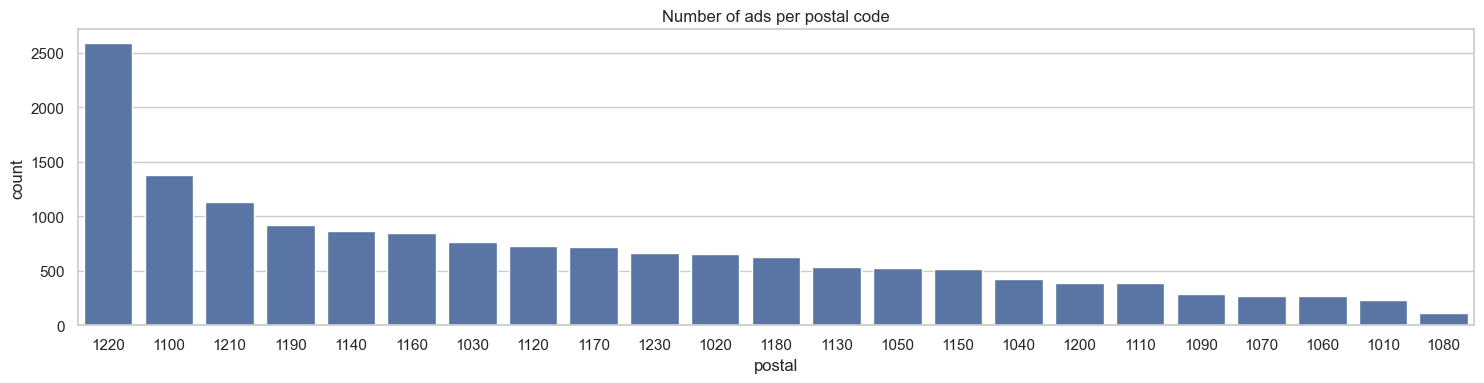

In [98]:
copy = df.copy()
copy = copy[copy["postal"] != 0]
copy.sort_values(by="price", ascending=False)

plt.figure(figsize=(15, 4))
sns.countplot(x="postal", data=copy, order=copy["postal"].value_counts().index)
plt.title("Number of ads per postal code")
plt.tight_layout()
plt.show()

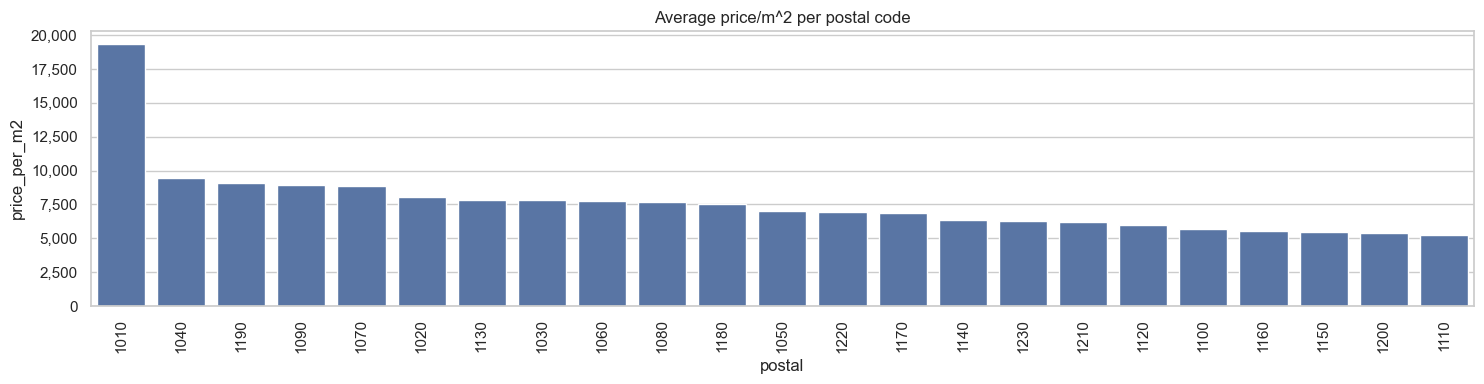

In [88]:
copy = df.copy()
copy["price_per_m2"] = copy["price"] / copy["m2"]
copy = copy[copy["postal"] != 0]
copy = copy.groupby("postal")["price_per_m2"].mean().reset_index()
copy = copy.sort_values(by="price_per_m2", ascending=False)

plt.figure(figsize=(15, 4))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
sns.barplot(x="postal", y="price_per_m2", data=copy, order=copy["postal"])
plt.xticks(rotation=90)

plt.title("Average price/m^2 per postal code")
plt.tight_layout()
plt.show()

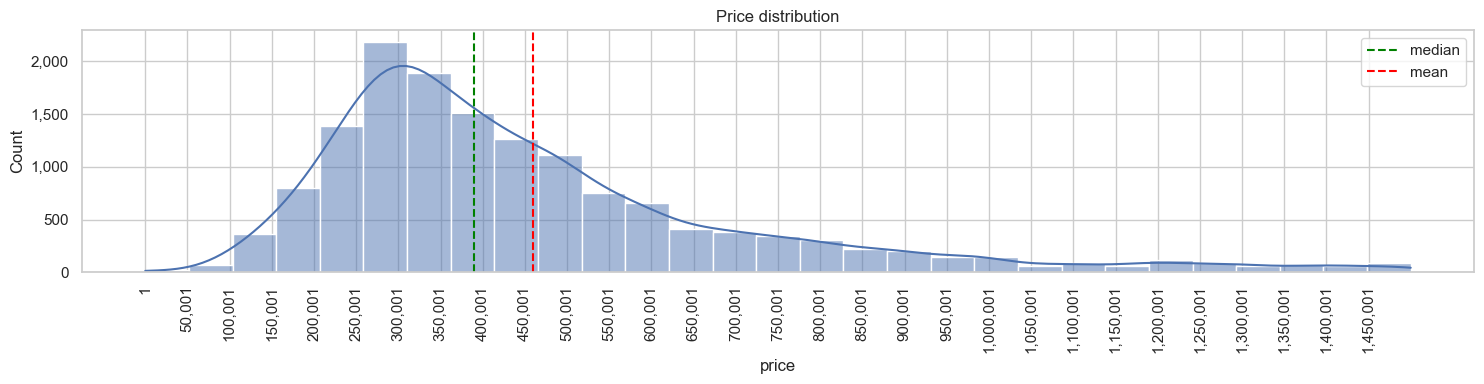

In [84]:
copy = df.copy()

# remove outliers
minval = copy["price"].min()
maxval = 1_500_000
copy = copy[copy["price"] > minval]
copy = copy[copy["price"] < maxval]

# set step size
step = 50_000
num_buckets = int((maxval - minval) // step)

plt.figure(figsize=(15, 4))
sns.histplot(copy["price"], bins=num_buckets, kde=True)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.xticks(np.arange(minval, maxval, step), rotation=90)
plt.title("Price distribution")

plt.axvline(copy["price"].median(), color="green", linestyle="--", label="median")
plt.axvline(copy["price"].mean(), color="red", linestyle="--", label="mean")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

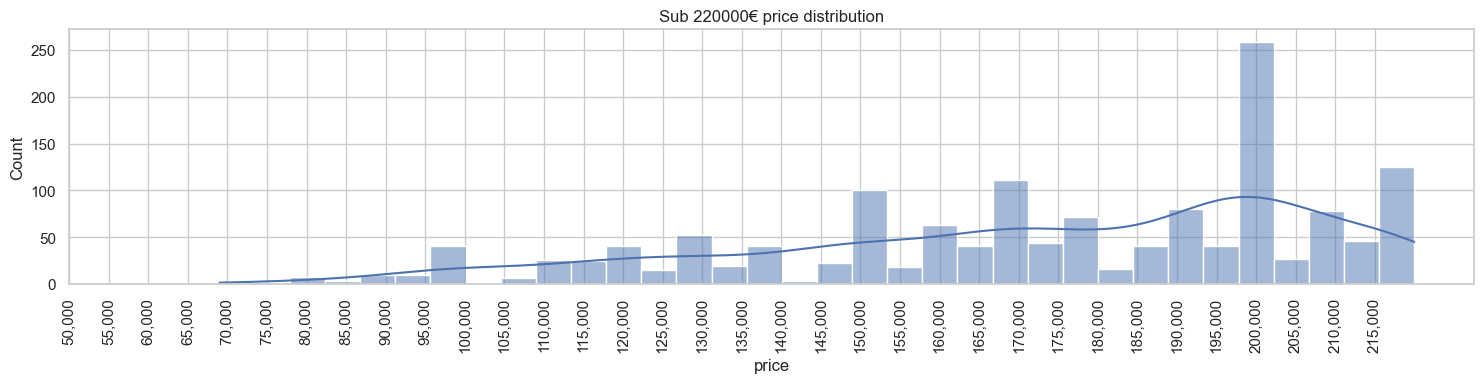

In [86]:
copy = df.copy()

# remove outliers
minval = 50_000
maxval = 220_000
copy = copy[copy["price"] > minval]
copy = copy[copy["price"] < maxval]

# set step size
step = 5_000
num_buckets = int((maxval - minval) // step)

plt.figure(figsize=(15, 4))
sns.histplot(copy["price"], bins=num_buckets, kde=True)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.xticks(np.arange(minval, maxval, step), rotation=90)
plt.title(f"Sub {maxval}€ price distribution")

plt.tight_layout()
plt.show()